## Import Libraries


In [17]:
import numpy as np 
import pandas as pd 
import os

import datetime as dt
from datetime import datetime

import matplotlib.pyplot as plt
plt.style.use('ggplot')

import numpy as np

from sklearn.preprocessing import MinMaxScaler

### Create the Stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from keras.layers import Dropout

## Loading Stock Data

In [18]:
data = './data/AMZN.csv'

In [19]:
df = pd.read_csv(data)
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2012-01-03,175.889999,179.479996,175.550003,179.029999,179.029999,5110800
1,2012-01-04,179.210007,180.500000,176.070007,177.509995,177.509995,4205200
2,2012-01-05,175.940002,178.250000,174.050003,177.610001,177.610001,3809100
3,2012-01-06,178.070007,184.649994,177.500000,182.610001,182.610001,7008400
4,2012-01-09,182.759995,184.369995,177.000000,178.559998,178.559998,5056900


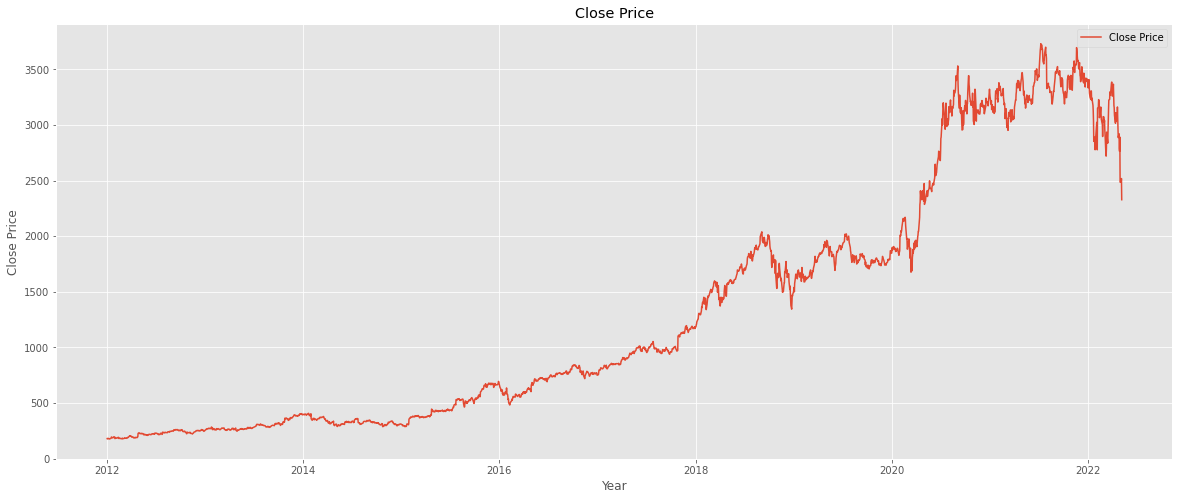

In [20]:
df['Date'] = pd.to_datetime(df.Date,format='%Y-%m-%d')
df.index = df['Date']
plt.figure(figsize=(20,8))
plt.plot(df['Close'], label='Close Price')
plt.xlabel('Year')
plt.ylabel('Close Price') 
plt.title('Close Price')
plt.legend() 

In [21]:
features = ["Date", "Close"]
all_data = df[features]
all_data.index = all_data.Date
all_data.drop('Date', axis=1, inplace=True)

/home/codevardhan/.env-list/mach-env/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [36]:
# all_data.head()
all_data.shape

(2603, 1)

## Pre-processing Stock Data

In [37]:
dataset = all_data.values
train = dataset[0:2000,:]
valid = dataset[2000:,:]

In [38]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

In [39]:
x_train, y_train = [], []
for i in range(90,len(train)):
    x_train.append(scaled_data[i-90:i,0])
    y_train.append(scaled_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)

In [40]:
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

In [41]:
inputs = all_data[len(all_data) - len(valid)-90:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)
inputs.shape
X_test = []
for i in range(90, inputs.shape[0]):
    X_test.append(inputs[i-90:i,0])
X_test = np.array(X_test)

## Making the model

In [42]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(Dropout(rate = 0.3))

model.add(LSTM(units=50, return_sequences = True))
model.add(Dropout(rate = 0.3))

model.add(LSTM(units=50, return_sequences = True))
model.add(Dropout(rate = 0.3))

model.add(LSTM(units=50, return_sequences = False))
model.add(Dropout(rate = 0.3))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

## Training the model

In [43]:
model.fit(x_train, y_train, epochs=100, batch_size=128, verbose=1)

Epoch 1/100
15/15 [==============================] - 9s 211ms/step - loss: 0.0134
Epoch 2/100
15/15 [==============================] - 3s 207ms/step - loss: 0.0025
Epoch 3/100
15/15 [==============================] - 3s 207ms/step - loss: 0.0018
Epoch 4/100
15/15 [==============================] - 3s 206ms/step - loss: 0.0014
Epoch 5/100
15/15 [==============================] - 3s 207ms/step - loss: 0.0011
Epoch 6/100
15/15 [==============================] - 3s 201ms/step - loss: 0.0011
Epoch 7/100
15/15 [==============================] - 3s 186ms/step - loss: 0.0011
Epoch 8/100
15/15 [==============================] - 3s 204ms/step - loss: 9.7624e-04 1s - loss: 9.93
Epoch 9/100
15/15 [==============================] - 3s 204ms/step - loss: 0.0010
Epoch 10/100
15/15 [==============================] - 3s 199ms/step - loss: 9.9006e-04
Epoch 11/100
15/15 [==============================] - 3s 184ms/step - loss: 8.8193e-04
Epoch 12/100
15/15 [==============================] - 3s 214ms/step 

In [44]:
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1))
preds = model.predict(X_test)
preds = scaler.inverse_transform(preds)

# print(X_test)

In [45]:
print(preds.shape)

(603, 1)


In [46]:
print(valid.shape)

(603, 1)


In [47]:
print(valid[-1],preds[-1])

[2328.139893] [2645.2585]


## Results

In [48]:
rms=np.sqrt(np.mean(np.power((valid-preds),2)))
rms

321.82353655392086

/tmp/ipykernel_11003/3655449250.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = preds


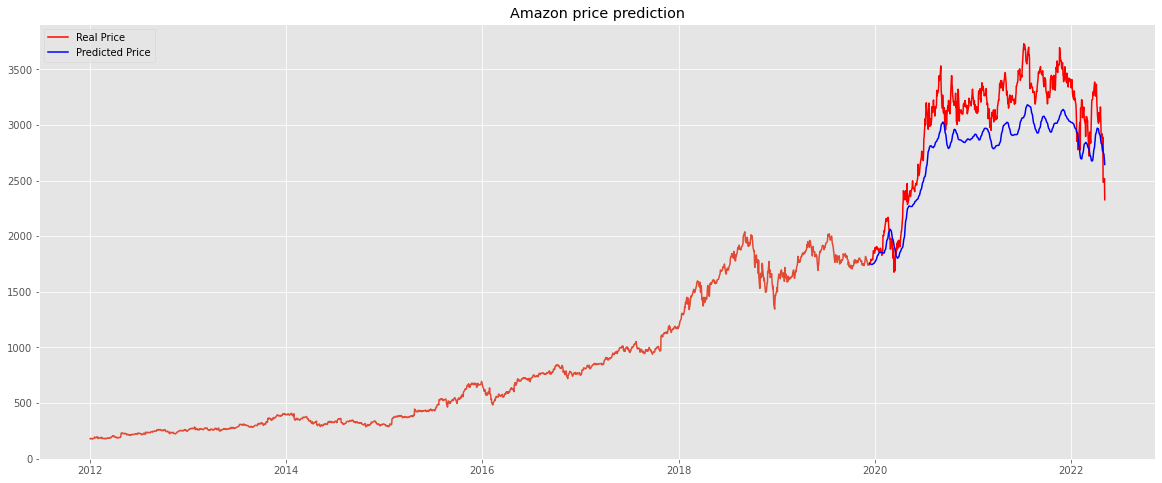

In [51]:
train = all_data[0:2000]
valid = all_data[2000:]
valid['Predictions'] = preds
plt.figure(figsize=(20,8))
plt.plot(train['Close'])
plt.plot(valid['Close'], color = 'red', label = 'Real Price')
plt.plot(valid['Predictions'], color = 'blue', label = 'Predicted Price')
plt.title('Amazon price prediction')
plt.legend()
plt.show()

In [52]:
valid.to_csv('output/preds_no_sent.csv')

In [ ]:
from keras.models import load_model
model.save('AMZN.h5')  # creates a HDF5 file 